In [4]:
!pip install kagglehub

In [5]:
import kagglehub
path = kagglehub.dataset_download("tthien/shanghaitech-with-people-density-map")
print("Path to dataset files:", path)

100%|██████████| 4.79G/4.79G [00:35<00:00, 143MB/s] 

Extracting files...


Path to dataset files: /teamspace/studios/this_studio/.cache/kagglehub/datasets/tthien/shanghaitech-with-people-density-map/versions/1


In [7]:
import shutil
import os
source_path = "/content/dataset"
destination_path = "/teamspace/studios/this_studio/dataset"
if not os.path.exists(destination_path):
    os.makedirs(destination_path)
shutil.move(source_path, destination_path)
print(f"Folder moved from '{source_path}' to '{destination_path}'")

Folder moved from '/content/dataset' to '/teamspace/studios/this_studio/dataset'


In [8]:
import os

def print_folders_only(path, indent=0):
    """Prints only the folders within the given path."""
    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            print("  " * indent + item) 
            print_folders_only(item_path, indent + 1)  

dataset_path = "/teamspace/studios/this_studio/dataset/dataset"
print_folders_only(dataset_path)

1
  shanghaitech_with_people_density_map
    ShanghaiTech
      part_A
        train_data
          images
          ground-truth-h5
          ground-truth
        test_data
          images
          ground-truth-h5
          ground-truth
      part_B
        train_data
          images
          ground-truth-h5
          ground-truth
        test_data
          images
          ground-truth-h5
          ground-truth
  ShanghaiTech
    part_A
      train_data
        images
        ground-truth-h5
        ground-truth
      test_data
        images
        ground-truth-h5
        ground-truth
    part_B
      train_data
        images
        ground-truth-h5
        ground-truth
      test_data
        images
        ground-truth-h5
        ground-truth


In [1]:
!pip install numpy scipy h5py opencv-python torch torchvision

In [2]:
import os
import cv2
import torch
import numpy as np
import scipy.io as sio
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim

In [3]:
import os
import cv2
import torch
import numpy as np
import scipy.io as sio
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim
class ShanghaiTechDataset(Dataset):
    def __init__(self, root_dir, part='A', train=True, transform=None):
        self.root_dir = root_dir
        self.part = part
        self.split = 'train_data' if train else 'test_data'
        self.image_dir = os.path.join(root_dir, f'ShanghaiTech/part_{self.part}', self.split, 'images')
        self.gt_dir = os.path.join(root_dir, f'ShanghaiTech/part_{self.part}', self.split, 'ground-truth')
        self.image_paths = sorted(glob(os.path.join(self.image_dir, '*.jpg')))
        self.gt_paths = sorted(glob(os.path.join(self.gt_dir, 'GT_*.mat')))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        gt_path = self.gt_paths[idx]
        points = sio.loadmat(gt_path)['image_info'][0, 0][0, 0][0]
        
        density_map = generate_density_map(image, points)
        downsample_factor = 8
        density_map = cv2.resize(
            density_map, 
            (density_map.shape[1] // downsample_factor, density_map.shape[0] // downsample_factor), 
            interpolation=cv2.INTER_LINEAR
        )
        if self.transform:
            image = self.transform(image)
        
        return image, torch.from_numpy(density_map).unsqueeze(0)  

def generate_density_map(image, points, sigma=15):
    density_map = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)
    for point in points:
        x = min(image.shape[1] - 1, max(0, int(point[0])))
        y = min(image.shape[0] - 1, max(0, int(point[1])))
        density_map[y, x] += 1
    density_map = cv2.GaussianBlur(density_map, (sigma, sigma), 0)
    return density_map

class CSRNet(nn.Module):
    def __init__(self, load_weights=True):
        super(CSRNet, self).__init__()
        
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat = [512, 512, 512, 256, 128, 64]
        
        self.frontend = self.make_layers(self.frontend_feat)
        self.backend = self.make_layers(self.backend_feat, in_channels=512, batch_norm=False)
        
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

        if load_weights:
            mod = models.vgg16(pretrained=True)
            self.frontend.load_state_dict(mod.features[:23].state_dict())

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x

    def make_layers(self, cfg, in_channels=3, batch_norm=False):
        layers = []
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
root_dir = '/teamspace/studios/this_studio/dataset/dataset/1'
train_dataset = ShanghaiTechDataset(root_dir, part='A', train=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataset = ShanghaiTechDataset(root_dir, part='A', train=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for images, density_maps in dataloader:
        images = images.to(device)
        density_maps = density_maps.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        
        if outputs.shape != density_maps.shape:
            density_maps = nn.functional.interpolate(density_maps, size=outputs.shape[2:], mode='bilinear')
        
        loss = criterion(outputs, density_maps)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader, device):
    model.eval()
    total_mae = 0
    with torch.no_grad():
        for images, density_maps in dataloader:
            images = images.to(device)
            density_maps = density_maps.to(device)
            
            outputs = model(images)
            mae = torch.abs(outputs.sum() - density_maps.sum()).item()
            total_mae += mae
    return total_mae / len(dataloader)




In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CSRNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 3000
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_mae = evaluate(model, test_loader, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation MAE: {val_mae:.2f}")

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/3000, Train Loss: 0.0007, Validation MAE: 13.81
Epoch 2/3000, Train Loss: 0.0001, Validation MAE: 11.42
Epoch 3/3000, Train Loss: 0.0001, Validation MAE: 11.78
Epoch 4/3000, Train Loss: 0.0001, Validation MAE: 8.33
Epoch 5/3000, Train Loss: 0.0000, Validation MAE: 15.32
Epoch 6/3000, Train Loss: 0.0000, Validation MAE: 23.85
Epoch 7/3000, Train Loss: 0.0000, Validation MAE: 21.95
Epoch 8/3000, Train Loss: 0.0000, Validation MAE: 7.82
Epoch 9/3000, Train Loss: 0.0000, Validation MAE: 11.81
Epoch 10/3000, Train Loss: 0.0000, Validation MAE: 9.23
Epoch 11/3000, Train Loss: 0.0000, Validation MAE: 15.08
Epoch 12/3000, Train Loss: 0.0000, Validation MAE: 10.30
Epoch 13/3000, Train Loss: 0.0000, Validation MAE: 15.47
Epoch 14/3000, Train Loss: 0.0000, Validation MAE: 7.50
Epoch 15/3000, Train Loss: 0.0000, Validation MAE: 6.58
Epoch 16/3000, Train Loss: 0.0000, Validation MAE: 5.30
Epoch 17/3000, Train Loss: 0.0000, Validation MAE: 5.97
Epoch 18/3000, Train Loss: 0.0000, Validation M

In [5]:
torch.save(model.state_dict(), 'csrnet_model_final.pth')


In [39]:
model = CSRNet().to(device)
model.load_state_dict(torch.load('csrnet_model.pth'))
model.eval() 


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CSRNet(
  (frontend): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [5]:
import torch
import cv2
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def count_objects(model, image, device, downsample_factor=8):
    model.eval() 
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    image_tensor = transform(image_rgb).unsqueeze(0).to(device) 
    
    with torch.no_grad(): 
        output = model(image_tensor) 
    
    density_map = output.squeeze().cpu().numpy()

    
    original_height, original_width = image.shape[:2]
    density_map_rescaled = cv2.resize(density_map, (original_width, original_height), interpolation=cv2.INTER_LINEAR)

    total_count = density_map_rescaled.sum()

    return total_count


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


model = CSRNet().to(device)
model.load_state_dict(torch.load('/teamspace/studios/this_studio/csrnet2_model.pth'))
model.eval()
image_path = '/teamspace/studios/this_studio/t1.png' 
image = cv2.imread(image_path)

total_count = count_objects(model, image, device)
print(f"Total objects detected: {total_count}")


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total objects detected: 817.0054931640625


In [6]:
import torch
import cv2
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def count_objects_and_show_heatmap(model, image, device, downsample_factor=8):
    model.eval()  
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
    image_tensor = transform(image_rgb).unsqueeze(0).to(device)  
    
    with torch.no_grad():  
        output = model(image_tensor) 
    
    density_map = output.squeeze().cpu().numpy()

    
    original_height, original_width = image.shape[:2]
    density_map_rescaled = cv2.resize(density_map, (original_width, original_height), interpolation=cv2.INTER_LINEAR)

    # Total count is the sum of all values in the density map
    total_count = density_map_rescaled.sum()

    # Visualization: Plotting the heatmap
    plt.figure(figsize=(10, 10))
    plt.imshow(density_map_rescaled, cmap='jet', interpolation='bilinear')  # Use 'jet' colormap for better heatmap visualization
    plt.colorbar()  # Show color bar
    plt.title(f"Heatmap - Total Count: {total_count:.2f}")
    plt.axis('off')  # Hide axes for better display
    plt.show()

    return total_count

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transform (same as used during training)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the model
model = CSRNet().to(device)
model.load_state_dict(torch.load('/teamspace/studios/this_studio/csrnet2_model.pth'))
model.eval()  # Set the model to evaluation mode

# Load an image (replace with your image path)
image_path = '/teamspace/studios/this_studio/s2.png'  # Replace with the actual image path
image = cv2.imread(image_path)

# Perform object counting and show heatmap
total_count = count_objects_and_show_heatmap(model, image, device)
print(f"Total objects detected: {total_count:.2f}")


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[ WARN:0@203.414] global loadsave.cpp:241 findDecoder imread_('/teamspace/studios/this_studio/s2.png'): can't open/read file: check file path/integrity


error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


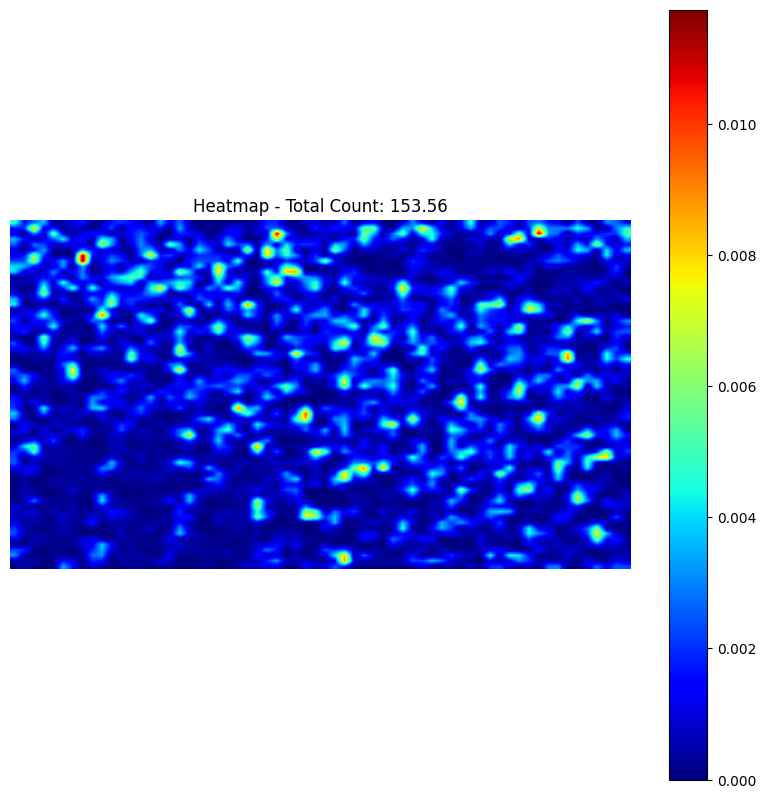

Total objects detected: 153.56


In [7]:
import torch
import cv2
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Function to count objects based on the density map and visualize the heatmap
def count_objects_and_show_heatmap(model, image, device, downsample_factor=8):
    model.eval()  # Set model to evaluation mode
    
    # Preprocess the image (convert to RGB, resize, normalize)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image_tensor = transform(image_rgb).unsqueeze(0).to(device)  # Apply transform and add batch dimension
    
    with torch.no_grad():  # Disable gradient calculation during inference
        output = model(image_tensor)  # Get the output density map from the model
    
    # Convert the output to a numpy array (remove batch dimension)
    density_map = output.squeeze().cpu().numpy()

    # Clamping to avoid negative values in the density map
    density_map = np.maximum(density_map, 0)  # Set negative values to 0
    
    # Rescale the density map back to the original image size (if downsampling was applied)
    original_height, original_width = image.shape[:2]
    density_map_rescaled = cv2.resize(density_map, (original_width, original_height), interpolation=cv2.INTER_LINEAR)

    # Total count is the sum of all values in the density map
    total_count = density_map_rescaled.sum()

    # Visualization: Plotting the heatmap
    plt.figure(figsize=(10, 10))
    plt.imshow(density_map_rescaled, cmap='jet', interpolation='bilinear')  # Use 'jet' colormap for better heatmap visualization
    plt.colorbar()  # Show color bar
    plt.title(f"Heatmap - Total Count: {total_count:.2f}")
    plt.axis('off')  # Hide axes for better display
    plt.show()

    return total_count

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transform (same as used during training)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the model
model = CSRNet().to(device)
model.load_state_dict(torch.load('/teamspace/studios/this_studio/csrnet2_model.pth'))
model.eval()  # Set the model to evaluation mode

# Load an image (replace with your image path)
image_path = '/teamspace/studios/this_studio/t4.png'  # Replace with the actual image path
image = cv2.imread(image_path)

# Perform object counting and show heatmap
total_count = count_objects_and_show_heatmap(model, image, device)
print(f"Total objects detected: {total_count:.2f}")


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


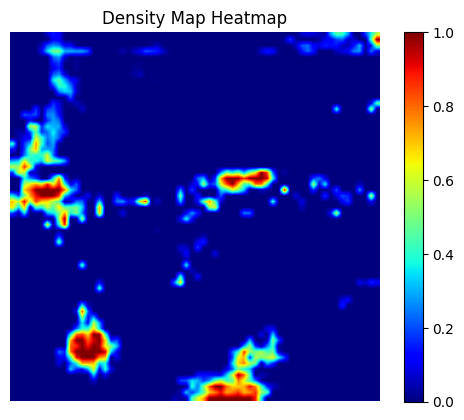

In [52]:
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms

# Function to generate and show the heatmap
def generate_heatmap(model, image, device):
    model.eval()  # Set the model to evaluation mode
    
    # Preprocess the image (apply transformations)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    image_tensor = transform(image_rgb).unsqueeze(0).to(device)  # Apply transform and add batch dimension
    
    with torch.no_grad():  # Disable gradient calculation during inference
        output = model(image_tensor)  # Get the output density map from the model
    
    # Convert the output to a numpy array (remove batch dimension)
    density_map = output.squeeze().cpu().numpy()

    # Normalize the density map for better visualization
    density_map = np.clip(density_map, 0, np.percentile(density_map, 99))  # Clip for visualization
    density_map = density_map / density_map.max()  # Normalize to [0, 1]
    
    # Plot the heatmap
    plt.imshow(density_map, cmap='jet', interpolation='bilinear')  # Use the 'jet' colormap
    plt.colorbar()  # Show color scale
    plt.title('Density Map Heatmap')
    plt.axis('off')  # Turn off axes
    plt.show()

    # Optionally, save the heatmap as an image
    plt.imsave('density_map_heatmap.png', density_map, cmap='jet')

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transform (same as used during training)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the model
model = CSRNet().to(device)
model.load_state_dict(torch.load('/teamspace/studios/this_studio/csrnet_model.pth'))
model.eval()  # Set the model to evaluation mode

# Load an image (replace with your image path)
image_path = '/teamspace/studios/this_studio/t2.png'  # Replace with the actual image path
image = cv2.imread(image_path)

# Generate and show the heatmap
generate_heatmap(model, image, device)


In [ ]:
import torch

# Define the path where you want to save the model
model_path = "csr_crowd_counting_model.pth"

# Save the model's state dictionary (recommended way)
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


In [28]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset
import scipy.io as sio
from glob import glob

class ShanghaiTechDataset(Dataset):
    def __init__(self, root_dir, part='A', train=True, transform=None):
        self.root_dir = root_dir
        self.part = part
        self.split = 'train_data' if train else 'test_data'
        self.image_dir = os.path.join(root_dir, f'ShanghaiTech/part_{self.part}', self.split, 'images')
        self.gt_dir = os.path.join(root_dir, f'ShanghaiTech/part_{self.part}', self.split, 'ground-truth')
        self.image_paths = sorted(glob(os.path.join(self.image_dir, '*.jpg')))
        self.gt_paths = sorted(glob(os.path.join(self.gt_dir, 'GT_*.mat')))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load and process the image
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Load ground truth points
        gt_path = self.gt_paths[idx]
        points = sio.loadmat(gt_path)['image_info'][0, 0][0, 0][0]
        
        # Generate the density map
        density_map = generate_density_map(image, points)
        
        # Downsample the density map to match CSRNet output dimensions
        downsample_factor = 8
        density_map = cv2.resize(
            density_map, 
            (density_map.shape[1] // downsample_factor, density_map.shape[0] // downsample_factor), 
            interpolation=cv2.INTER_LINEAR)



        # Apply transformations to the image if provided
        if self.transform:
            image = self.transform(image)
        
        # Return image and density map as tensors
        return image, torch.from_numpy(density_map).unsqueeze(0)

def generate_density_map(image, points, sigma=15):
    """
    Generate a density map based on the given annotated points.
    """
    # Initialize density map with zeros
    density_map = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)
    
    # Generate density map using Gaussian blobs at each annotated point
    for point in points:
        x = min(image.shape[1] - 1, max(0, int(point[0])))
        y = min(image.shape[0] - 1, max(0, int(point[1])))
        density_map[y, x] += 1
    
    # Apply Gaussian Blur to spread out the points
    density_map = cv2.GaussianBlur(density_map, (sigma, sigma), 0)
    
    return density_map


In [29]:
class CSRNet(nn.Module):
    def __init__(self, load_weights=True):
        super(CSRNet, self).__init__()
        
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat = [512, 512, 512, 256, 128, 64]
        
        self.frontend = self.make_layers(self.frontend_feat)
        self.backend = self.make_layers(self.backend_feat, in_channels=512, batch_norm=False)
        
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

        if load_weights:
            mod = models.vgg16(pretrained=True)
            self.frontend.load_state_dict(mod.features[:23].state_dict())

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x

    def make_layers(self, cfg, in_channels=3, batch_norm=False):
        layers = []
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)


In [30]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

root_dir = '/teamspace/studios/this_studio/dataset/dataset/1'  # Replace with the path to your ShanghaiTech dataset

train_dataset = ShanghaiTechDataset(root_dir, part='A', train=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

test_dataset = ShanghaiTechDataset(root_dir, part='A', train=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [33]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    total_loss = 0
    for images, density_maps in dataloader:
        images = images.to(device)
        density_maps = density_maps.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        # Check shapes before loss calculation
        print("Output shape:", outputs.shape)
        print("Density map shape:", density_maps.shape)
        loss = criterion(outputs, density_maps)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader, device):
    model.eval()
    total_mae = 0
    with torch.no_grad():
        for images, density_maps in dataloader:
            images = images.to(device)
            density_maps = density_maps.to(device)
            
            outputs = model(images)
            mae = torch.abs(outputs.sum() - density_maps.sum()).item()
            total_mae += mae
    return total_mae / len(dataloader)


In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CSRNet().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

num_epochs = 50
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_mae = evaluate(model, test_loader, device)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation MAE: {val_mae:.2f}")


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Output shape: torch.Size([1, 1, 64, 64])
Density map shape: torch.Size([1, 1, 128, 128])


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1, 128, 128])) that is different to the input size (torch.Size([1, 1, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (64) must match the size of tensor b (128) at non-singleton dimension 3